# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

# Functions definition

In [19]:
# Function to convert the monthly values into yearly, to compute the radiative budget and to put them into a 
# dataframe adapted for the plotting part

import xarray as xr
import numpy as np
import pandas as pd

def get_N_year_dataframe(path, filename, variables,drop, year_list):
#    “”"
#    This funciton read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    df=file[variables].to_dataframe().drop('height',axis=1)
    df1=df.reset_index(level=['time'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df2=df1.groupby(['year']).mean()
    #
    # Compute radiative budget 
    df2['F']=df2['rsdt']
    df2['H']=df2['rsut']+df2['rlut']
    df2['N']=df2['F']-df2['H']
    #
    # reshape
    if drop == True:
        df3=df2.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
    else:
        df3=df2.reset_index(level=['year']).drop(axis=1,columns='year')
    #
    return df3

In [27]:
# Function to plot 4 lines from a data frame 

import matplotlib.pyplot as plt

def plot_lines_4(df1, df2, df3, df4, y, title, colors, xlabel, legend ):
    ax_model=plt.gca()
    df1.plot(y=y,kind='line',title=title,legend=True, color=colors[0],linewidth=2.5,ax=ax_model)
    df2.plot(y=y,kind='line',legend=True, color=colors[1],linewidth=2.5,ax=ax_model)
    df3.plot(y=y,kind='line',legend=True, color=colors[2],ax=ax_model)
    df4.plot(y=y,kind='line',legend=True, color=colors[3],ax=ax_model)
    plt.xlabel(xlabel)
    ax_model.legend(legend,
                loc='center left', bbox_to_anchor=(1, 0.5))
    #return ax

In [35]:
# Function to compute Delta(TOA), Delta(tas), Lambda

def Deltas_Lambda(result, df_CTL, df, expe_name):
    i=1
    N=len(official_amip)

    Lbda=[]
    DN=[]
    Dtas=[]

    while i<N:
    
        df_CTL_tmp=df_CTL.iloc[0:i,:]
        df_tmp=df.iloc[0:i,:]
        Delta_N=(df_tmp['N']-df_CTL_tmp['N']).mean()
        Delta_tas=(df_tmp['tas']-df_CTL_tmp['tas']).mean()
        Lambda=Delta_N/Delta_tas
        Lbda.append(Lambda)
        DN.append(Delta_N)
        Dtas.append(Delta_tas)
    
        i=i+1
 
    result['Delta_N_'+expe_name]=DN
    result['Delta_tas_'+expe_name]=Dtas
    result['Lambda_'+expe_name]=Lbda

    return result

# Read files : radiative budget, tas

In [21]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['rlut', 'rsut','rsdt','tas']


# The amip experiment : 
official_amip = get_N_year_dataframe(path_official, '*_amip_*.nc', 
                               variables, True , range(1989,2015,1))

p1_amip = get_N_year_dataframe(path_PPE+'CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/','*_amip_*.nc',
                            variables, False, None)

# The amip-4xCO2 experiment :
official_4xCO2 = get_N_year_dataframe(path_official,'*_amip-4xCO2_*.nc',
                            variables, True, range(1989,2015,1))

p1_4xCO2 = get_N_year_dataframe(path_PPE+'CNRM-CM6-1_amip-4xCO2_PPE/CNRM-CM6-1_amip-4xCO2_r1i1p1f2/', 
                                '*_amip-4xCO2_*.nc', variables, False, None)

# The amip-p4K experiment : 
official_p4K = get_N_year_dataframe(path_official, '*_amip-p4K_*.nc', 
                               variables, True , range(1989,2015,1))

p1_p4K = get_N_year_dataframe(path_PPE+'CNRM-CM6-1_amip-p4K_PPE/CNRM-CM6-1_amip-p4K_r1i1p1f2/', 
                              '*_amip-p4K_*.nc', variables, False, None)

# The amip-future4K experiment : 
official_future4K = get_N_year_dataframe(path_official, '*_amip-future4K_*.nc', variables, 
                                         True, range(1989,2015,1))

p1_future4K = get_N_year_dataframe(path_PPE+'CNRM-CM6-1_amip-future4K_PPE/CNRM-CM6-1_amip-future4K_r1i1p1f2/', 
                                   '*_amip-future4K_*.nc', variables, False, None)

## Create plot

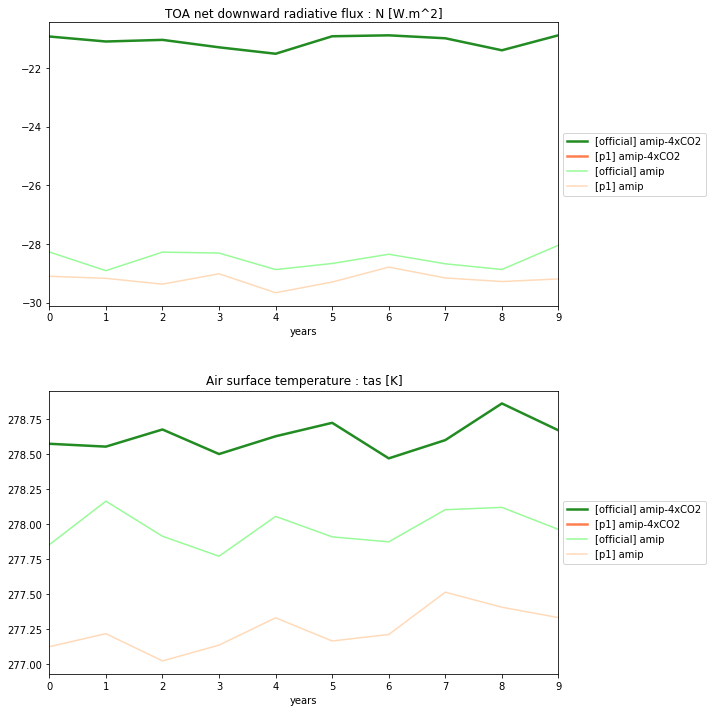

In [32]:
plt.subplots(figsize=(10,10))

plt.subplot(211)
title="TOA net downward radiative flux : N [W.m^2]"
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-4xCO2','[p1] amip-4xCO2','[official] amip','[p1] amip']
plot_lines_4(official_4xCO2, p1_4xCO2, official_amip, p1_amip, 'N', title, colors, xlabel, legend )

plt.subplot(212)
title='Air surface temperature : tas [K]'
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-4xCO2','[p1] amip-4xCO2','[official] amip','[p1] amip']
plot_lines_4(official_4xCO2, p1_4xCO2, official_amip, p1_amip, 'tas', title, colors, xlabel, legend )

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

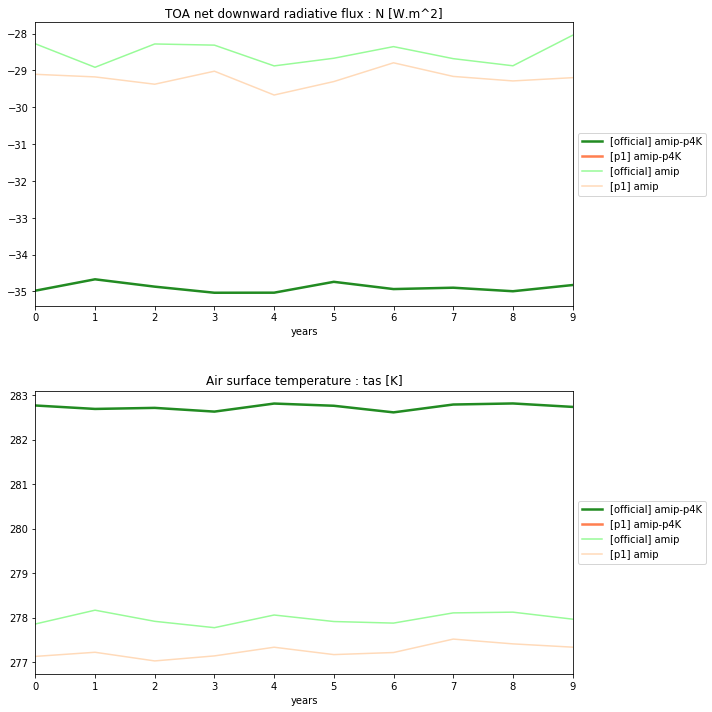

In [33]:
plt.subplots(figsize=(10,10))

plt.subplot(211)
title="TOA net downward radiative flux : N [W.m^2]"
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-p4K','[p1] amip-p4K','[official] amip','[p1] amip']
plot_lines_4(official_p4K, p1_p4K, official_amip, p1_amip, 'N', title, colors, xlabel, legend )

plt.subplot(212)
title='Air surface temperature : tas [K]'
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-p4K','[p1] amip-p4K','[official] amip','[p1] amip']
plot_lines_4(official_p4K, p1_p4K, official_amip, p1_amip, 'tas', title, colors, xlabel, legend )

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

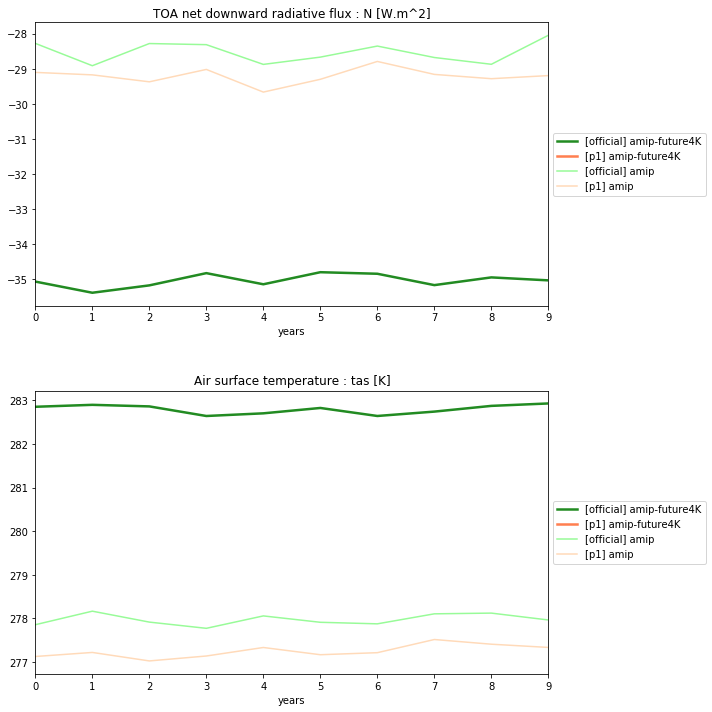

In [34]:
plt.subplots(figsize=(10,10))

plt.subplot(211)
title="TOA net downward radiative flux : N [W.m^2]"
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-future4K','[p1] amip-future4K','[official] amip','[p1] amip']
plot_lines_4(official_future4K, p1_future4K, official_amip, p1_amip, 'N', title, colors, xlabel, legend )

plt.subplot(212)
title='Air surface temperature : tas [K]'
colors=['forestgreen','coral','palegreen','peachpuff']
xlabel='years'
legend=['[official] amip-future4K','[p1] amip-future4K','[official] amip','[p1] amip']
plot_lines_4(official_future4K, p1_future4K, official_amip, p1_amip, 'tas', title, colors, xlabel, legend )

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Compute : Delta(TOA), Delta(tas), Lambda

In [39]:
result= pd.DataFrame()

result = Deltas_Lambda(result, official_amip, official_4xCO2, '4xCO2')
result = Deltas_Lambda(result, official_amip, official_p4K, 'p4K')
result = Deltas_Lambda(result, official_amip, official_future4K, 'future4K')

result

,Delta_N_4xCO2,Delta_tas_4xCO2,Lambda_4xCO2,Delta_N_p4K,Delta_tas_p4K,Lambda_p4K,Delta_N_future4K,Delta_tas_future4K,Lambda_future4K
0,7.350189,0.720551,10.200796,-6.701691,4.913544,-1.363922,-6.799255,4.998291,-1.360316
1,7.583893,0.555115,13.661847,-6.228592,4.719543,-1.319745,-6.639771,4.865326,-1.364712
2,7.469401,0.624268,11.965063,-6.348297,4.746297,-1.337526,-6.727458,4.892527,-1.375048
3,7.356522,0.650658,11.306286,-6.441551,4.774384,-1.349190,-6.676025,4.886787,-1.366138
4,7.357642,0.634985,11.587105,-6.384467,4.770556,-1.338307,-6.596069,4.838654,-1.363204
5,7.423147,0.664922,11.163935,-6.331940,4.784083,-1.323543,-6.519969,4.851450,-1.343922
6,7.429421,0.655099,11.340914,-6.367589,4.777610,-1.332798,-6.517016,4.839404,-1.346657
7,7.462406,0.635353,11.745290,-6.348873,4.766102,-1.332089,-6.514500,4.814228,-1.353176
8,7.464023,0.647247,11.531949,-6.323480,4.757992,-1.329023,-6.466570,4.807397,-1.345129


# Create plots

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


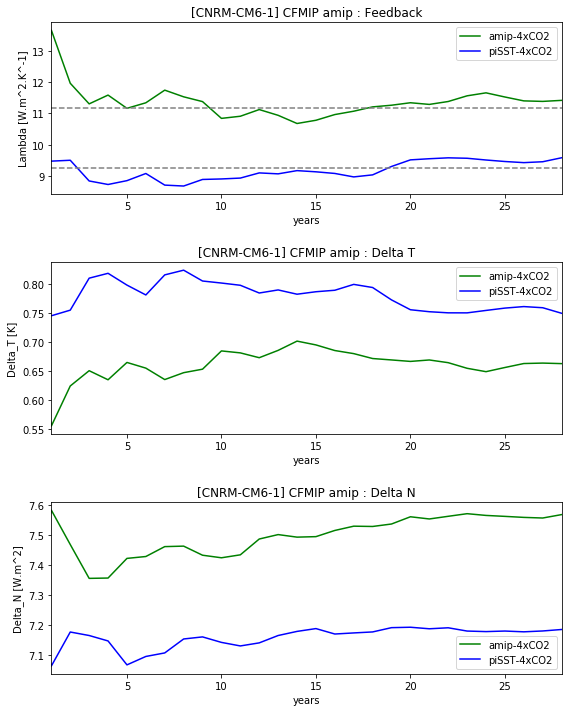

In [65]:
#--------------------------- Plot result : 4xCO2, amip and SST --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax2=plt.gca()
result.plot(y='Lambda_amip4xCO2',kind='line',title='[CNRM-CM6-1] CFMIP amip : Feedback',legend=True, color='green',ax=ax2)
result.plot(y='Lambda_sst',kind='line',legend=True, color='blue',ax=ax2)
ax2.axhline(y=Lamip, xmin=0, xmax=36, ls='--', color='grey')
ax2.axhline(y=Lsst, xmin=0, xmax=36, ls='--', color='grey')
ax2.set_xlabel('years')
ax2.set_ylabel('Lambda [W.m^2.K^-1]')
ax2.legend(['amip-4xCO2','piSST-4xCO2'])
#ax2.set_ylim([6,10])
ax2.set_xlim([1,28])

plt.subplot(312)
ax3=plt.gca()
result.plot(y='Delta_tas_amip4xCO2',kind='line',title='[CNRM-CM6-1] CFMIP amip : Delta T',legend=True, color='green',ax=ax3)
result.plot(y='Delta_tas_sst',kind='line',legend=True, color='blue',ax=ax3)
ax3.set_xlabel('years')
ax3.set_ylabel('Delta_T [K]')
ax3.legend(['amip-4xCO2','piSST-4xCO2'])
#ax3.set_ylim([0,2])
ax3.set_xlim([1,28])

plt.subplot(313)
ax4=plt.gca()
result.plot(y='Delta_N_amip4xCO2',kind='line',color='green',title='[CNRM-CM6-1] CFMIP amip : Delta N',legend=True,ax=ax4)
result.plot(y='Delta_N_sst',kind='line',color='blue',legend=True,ax=ax4)
ax4.set_xlabel('years')
ax4.set_ylabel('Delta_N [W.m^2]')
ax4.legend(['amip-4xCO2','piSST-4xCO2'])
#ax4.set_ylim([6.5,8.5])
ax4.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-piSST_CNRM.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


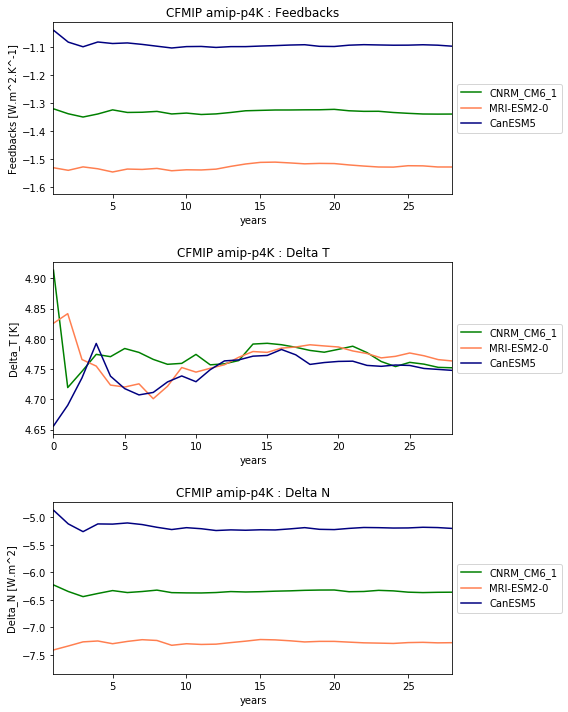

In [69]:
#--------------------------- Plot result : p4K --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_4K=plt.gca()
result.plot(y='Lambda_amip4K',kind='line',title='CFMIP amip-p4K : Feedbacks',legend=True, color='green',ax=ax_4K)
result.plot(y='Lambda_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K)
result.plot(y='Lambda_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K)
ax_4K.set_xlabel('years')
ax_4K.set_ylabel('Feedbacks [W.m^2.K^-1]')
ax_4K.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax2.set_ylim([6,10])
ax_4K.set_xlim([1,28])

plt.subplot(312)
ax_4K1=plt.gca()
result.plot(y='Delta_tas_amip4K',kind='line',title='CFMIP amip-p4K : Delta T',legend=True, color='green',ax=ax_4K1)
result.plot(y='Delta_tas_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K1)
result.plot(y='Delta_tas_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K1)
ax_4K1.set_xlabel('years')
ax_4K1.set_ylabel('Delta_T [K]')
ax_4K1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K1.set_ylim([0,3])
ax3.set_xlim([1,28])

plt.subplot(313)
ax_4K2=plt.gca()
result.plot(y='Delta_N_amip4K',kind='line',color='green',title='CFMIP amip-p4K : Delta N',legend=True,ax=ax_4K2)
result.plot(y='Delta_N_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K2)
result.plot(y='Delta_N_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K2)
ax_4K2.set_xlabel('years')
ax_4K2.set_ylabel('Delta_N [W.m^2]')
ax_4K2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K2.set_ylim([6.5,9.5])
ax_4K2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-p4K_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


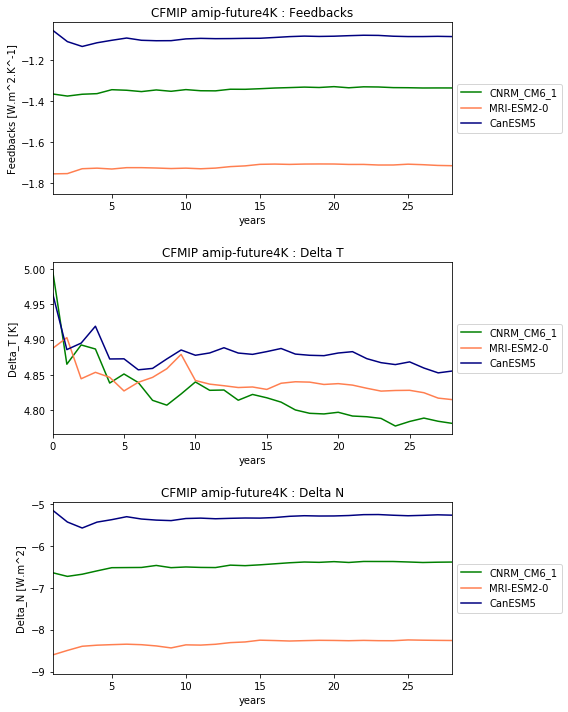

In [70]:
#--------------------------- Plot result : future4K --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_4K=plt.gca()
result.plot(y='Lambda_amipfuture4K',kind='line',title='CFMIP amip-future4K : Feedbacks',legend=True, color='green',ax=ax_4K)
result.plot(y='Lambda_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K)
result.plot(y='Lambda_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K)
ax_4K.set_xlabel('years')
ax_4K.set_ylabel('Feedbacks [W.m^2.K^-1]')
ax_4K.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax2.set_ylim([6,10])
ax_4K.set_xlim([1,28])

plt.subplot(312)
ax_4K1=plt.gca()
result.plot(y='Delta_tas_amipfuture4K',kind='line',title='CFMIP amip-future4K : Delta T',legend=True, color='green',ax=ax_4K1)
result.plot(y='Delta_tas_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K1)
result.plot(y='Delta_tas_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K1)
ax_4K1.set_xlabel('years')
ax_4K1.set_ylabel('Delta_T [K]')
ax_4K1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K1.set_ylim([0,3])
ax3.set_xlim([1,28])

plt.subplot(313)
ax_4K2=plt.gca()
result.plot(y='Delta_N_amipfuture4K',kind='line',color='green',title='CFMIP amip-future4K : Delta N',legend=True,ax=ax_4K2)
result.plot(y='Delta_N_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K2)
result.plot(y='Delta_N_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K2)
ax_4K2.set_xlabel('years')
ax_4K2.set_ylabel('Delta_N [W.m^2]')
ax_4K2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K2.set_ylim([6.5,9.5])
ax_4K2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-future4K_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


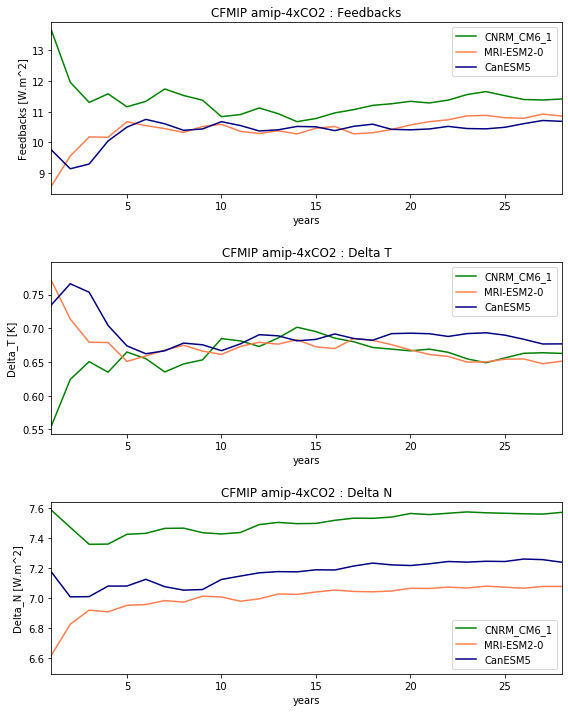

In [73]:
#--------------------------- Plot result : 4xCO2, multi-model--------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_multimodel=plt.gca()
result.plot(y='Lambda_amip4xCO2',kind='line',title='CFMIP amip-4xCO2 : Feedbacks',legend=True, color='green',ax=ax_multimodel)
result.plot(y='Lambda_mri4xCO2',kind='line',legend=True, color='coral',ax=ax_multimodel)
result.plot(y='Lambda_Can4xCO2',kind='line',legend=True, color='navy',ax=ax_multimodel)
ax_multimodel.set_xlabel('years')
ax_multimodel.set_ylabel('Feedbacks [W.m^2]')
ax_multimodel.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel.set_ylim([6,10])
ax_multimodel.set_xlim([1,28])

plt.subplot(312)
ax_multimodel1=plt.gca()
result.plot(y='Delta_tas_amip4xCO2',kind='line',title='CFMIP amip-4xCO2 : Delta T',legend=True, color='green',ax=ax_multimodel1)
result.plot(y='Delta_tas_mri4xCO2',kind='line',legend=True, color='coral',ax=ax_multimodel1)
result.plot(y='Delta_tas_Can4xCO2',kind='line',legend=True, color='navy',ax=ax_multimodel1)
ax_multimodel1.set_xlabel('years')
ax_multimodel1.set_ylabel('Delta_T [K]')
ax_multimodel1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel1.set_ylim([0,2])
ax_multimodel1.set_xlim([1,28])

plt.subplot(313)
ax_multimodel2=plt.gca()
result.plot(y='Delta_N_amip4xCO2',kind='line',color='green',title='CFMIP amip-4xCO2 : Delta N',legend=True,ax=ax_multimodel2)
result.plot(y='Delta_N_mri4xCO2',kind='line',color='coral',legend=True,ax=ax_multimodel2)
result.plot(y='Delta_N_Can4xCO2',kind='line',color='navy',legend=True,ax=ax_multimodel2)
ax_multimodel2.set_xlabel('years')
ax_multimodel2.set_ylabel('Delta_N [W.m^2]')
ax_multimodel2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel2.set_ylim([6.5,8.5])
ax_multimodel2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-4xCO2_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)